<a href="https://colab.research.google.com/github/bluealphanumeric9/Quantitative-Finance/blob/main/Derivatives_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Derivatives Pricing Model

### Essential Libraries

In [4]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import seaborn as sns
from math import log, exp, sqrt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

## Common Parameters

In [5]:
# Define common parameters for all models
S0 = 100.0       # Initial stock price
K = 105.0        # Strike price
T = 1.0          # Time to maturity (1 year)
r = 0.05         # Risk-free rate (5%)
sigma = 0.2      # Volatility (20%)

## Black-Scholes price for a European call/put option

In [6]:
def black_scholes(S0, K, T, r, sigma, option_type='call'):
    """
    Calculate the Black-Scholes price for a European call/put option.
    """
    # d1 and d2 calculations
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    if option_type == 'call':
        price = (S0 * si.norm.cdf(d1, 0.0, 1.0) -
                K * exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == 'put':
        price = (K * exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) -
                S0 * si.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return price

# Calculate and print the price
bs_price = black_scholes(S0, K, T, r, sigma, 'call')
print(f"Black-Scholes European Call Price: ${bs_price:.4f}")

Black-Scholes European Call Price: $8.0214


##Binomial Model -  Price a European option using the Binomial Tree model

In [7]:
def binomial_tree(S0, K, T, r, sigma, n_steps, option_type='call'):
    """
    Price a European option using the Binomial Tree model.
    """
    dt = T / n_steps
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    p = (exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    S = np.zeros(n_steps + 1)
    S[0] = S0 * (d ** n_steps)
    for j in range(1, n_steps + 1):
        S[j] = S[j-1] * (u / d)

    # Initialize option values at maturity
    V = np.zeros(n_steps + 1)
    for j in range(0, n_steps + 1):
        if option_type == 'call':
            V[j] = max(S[j] - K, 0)
        elif option_type == 'put':
            V[j] = max(K - S[j], 0)

    # Backward induction
    for i in range(n_steps - 1, -1, -1):
        for j in range(0, i + 1):
            V[j] = exp(-r * dt) * (p * V[j+1] + (1 - p) * V[j])

    return V[0]

# Calculate for different steps to show convergence
steps_list = [10, 50, 100, 500, 1000]
binom_prices = []
for n in steps_list:
    price = binomial_tree(S0, K, T, r, sigma, n, 'call')
    binom_prices.append(price)
    print(f"Binomial Price ({n} steps): ${price:.4f}")

# Compare to Black-Scholes
print(f"\nBlack-Scholes Benchmark: ${bs_price:.4f}")

Binomial Price (10 steps): $8.1763
Binomial Price (50 steps): $8.0143
Binomial Price (100 steps): $8.0262
Binomial Price (500 steps): $8.0232
Binomial Price (1000 steps): $8.0211

Black-Scholes Benchmark: $8.0214


##Monte Carlo Simulation for Asian Options

Monte Carlo Asian Call Price: $3.5536
Standard Error: ±$0.0205
95% Confidence Interval: ($3.5133, $3.5938)
Calculation time: 0:00:01.219184


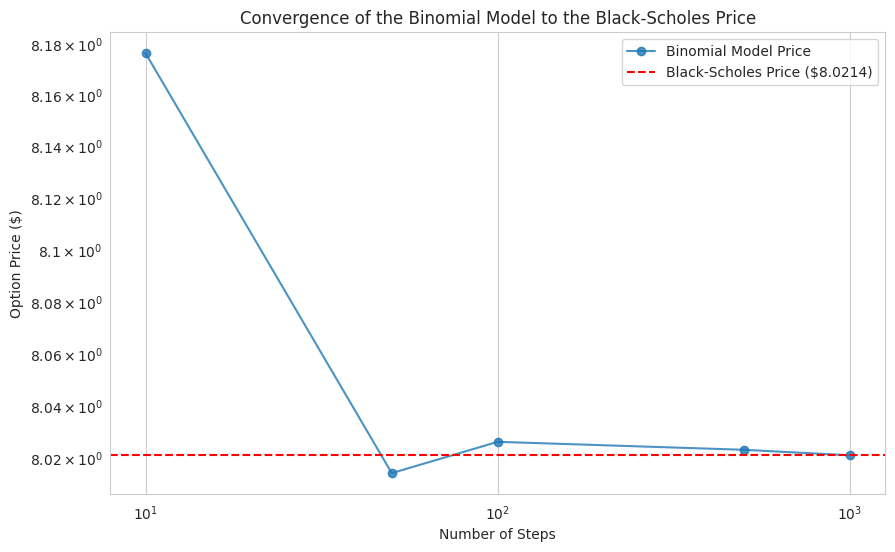

In [8]:
def monte_carlo_asian(S0, K, T, r, sigma, n_paths, n_steps, option_type='call'):
    """
    Price an Asian (arithmetic average) option using Monte Carlo simulation.
    """
    dt = T / n_steps
    discount_factor = np.exp(-r * T)

    # Generate random paths
    Z = np.random.standard_normal((n_paths, n_steps))
    # Simulate paths using Euler-Maruyama on GBM
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])

    # Calculate the arithmetic average price for each path
    average_price = np.mean(S[:, 1:], axis=1)

    # Calculate payoff for each path
    if option_type == 'call':
        payoffs = np.maximum(average_price - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - average_price, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Calculate option price as the discounted average payoff
    option_price = discount_factor * np.mean(payoffs)
    standard_error = discount_factor * np.std(payoffs) / np.sqrt(n_paths)

    return option_price, standard_error

# Run the simulation
n_paths = 100000
n_steps_mc = 252  # Daily steps for a year
start_time = datetime.now()
asian_price, asian_std_err = monte_carlo_asian(S0, K, T, r, sigma, n_paths, n_steps_mc, 'call')
end_time = datetime.now()

print(f"Monte Carlo Asian Call Price: ${asian_price:.4f}")
print(f"Standard Error: ±${asian_std_err:.4f}")
print(f"95% Confidence Interval: (${asian_price - 1.96*asian_std_err:.4f}, ${asian_price + 1.96*asian_std_err:.4f})")
print(f"Calculation time: {end_time - start_time}")

# Cell 11: Convergence Analysis Plot
plt.figure(figsize=(10, 6))
plt.plot(steps_list, binom_prices, 'o-', label='Binomial Model Price', alpha=0.8)
plt.axhline(bs_price, color='r', linestyle='--', label=f'Black-Scholes Price (${bs_price:.4f})')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price ($)')
plt.title('Convergence of the Binomial Model to the Black-Scholes Price')
plt.legend()
plt.loglog() # Use a log-log scale to better see convergence
plt.show()
